In [99]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
import regex as re
import requests
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import contractions
import nltk
from scipy import stats

import time
import spacy
import spacy.cli

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #clearing future warnings



pd.set_option('max_colwidth', 400)

# Data Collection

##### Get Submissions method

In [877]:
def get_submission(theme, requests_amount):
    list_submission=[]
    counter=0
    sum=0
    for x in range(1,requests_amount+1):
        url_topic_1=f"https://api.pushshift.io/reddit/search/submission/?subreddit={theme}&fields=selftext,removed_by_category&size=100&before={counter}d"
        req_1=requests.get(url_topic_1)
        #to avoid overrequesting API, code is waiting for a second after request
        time.sleep(1)

        if req_1.status_code==200:
            counter+=1
            sq=req_1.json()            
            for x in sq["data"]:
                #I am checking "removed by category" field, to exclude spam and inappropriate posts, deleted by bot.
                if "removed_by_category" not in x:
                    list_submission.append(x["selftext"])
                    sum+=1                
        else:
            print(f"There was a mistake {req_1.status_code}")
            return list_submission
    print(f"{sum} submissions downloaded")       
    return list_submission

##### Get commentaries method

In [1086]:
#processing url and getting list of comments

def get_comment(theme,quant):
    list_comments=[]
    counter=0
    for x in range(1,36,2):
        url_topic_1=f"https://api.pushshift.io/reddit/search/comment/?size={quant}&subreddit={theme}&before={x}d"
        req_1=requests.get(url_topic_1)
        if counter%2==0:
            #Waiting for a second each 2nd request
            time.sleep(1)
        if req_1.status_code==200:
            counter+=1
            sq=req_1.json()            
            for x in sq["data"]:
                list_comments.append(x['body'])                
        else:
            return f"Code was {req_1.status_code}"
    return list_comments

##### Cleaning with RegExp

In [1869]:
#using regexp to clean recieved comments
def clean(sq):
    sq=[x.lower() for x in sq if x.find("Your submission has been")==-1] #drops posts of antispam bot
    sq=[x.lower() for x in sq if x!="delete"] # drops posts with "delete" in them
    sq=[x.lower() for x in sq if x.find("title")==-1] 
    sq=[re.sub("(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)"," ", x.lower()) for x in sq] #drops all links
    sq=[re.sub("(.)\1{2}"," ", x.lower()) for x in sq] # drops all words where 3 or more same letters are put together like "aaaaand", "soooooo"
    sq=[re.sub("\W+"," ", x.lower()) for x in sq] #drops all whitespace symbols like \n \t etc.
    sq=[re.sub("\w*\d\w*"," ", x.lower()) for x in sq] #drops all words with numbers in them 
    sq=[re.sub("\s[a-z]{1,2}\s"," ", x.lower()) for x in sq] #drops all two letter words, because almost all of them are Stop-words
    sq=[re.sub("\s[a-z]{1,1}\s"," ", x.lower()) for x in sq] #drops all one letter words,for some reason previous regex left some of those
    sq=[re.sub("^i+(?!$)"," ", x.lower()) for x in sq] #drops fist letter if it is i
    sq=[x.lower().strip() for x in sq if x.find("removed")==-1] #drops "removed" comments, sent by api 
    sq=[re.sub("^m+(?!$)"," ", x.lower()) for x in sq] #drops fist letter if it is m
    sq=set(sq) #Leaving only unique values

    
    return sq


#### Downloading and cleaning commentaries

In [1088]:
AskMan_comment=get_comment("AskMen",130)
len(set(AskMan_comment))

2183

In [1089]:
AskWoman_comment=get_comment("AskWomen",130)
len(set(AskWoman_comment))

2096

##### Adding columns for classification and saving dataset

In [1104]:
AskMan_comment=clean(set(AskMan_comment))
AskMan_comment_df=pd.DataFrame(AskMan_comment)
AskMan_comment_df['sex']=1
AskMan_comment_df.columns=["comment",'sex']

AskWoman_comment=clean(set(AskWoman_comment))
AskWoman_comment_df=pd.DataFrame(AskWoman_comment)
AskWoman_comment_df['sex']=0
AskWoman_comment_df.columns=["comment",'sex']

AskMan_comment_df.shape, AskWoman_comment_df.shape

In [ ]:
final_comment_df=pd.concat([AskMan_comment_df,AskWoman_comment_df])
final_comment_df.reset_index(inplace=True,drop=True)
final_comment_df

final_comment_df.to_csv('../data/df_comments.csv',index=False)

----

#### Downloading Submissions

In [839]:
AskMan=get_submission("AskMen",130)
AskWoman=get_submission("AskMen",130)


5335 submissions downloaded


In [1870]:
c_ask_man=clean(AskMan)
c_ask_woman=clean(AskWoman)
print(f"Unique AskMan comments:  {len(c_ask_man)}")
print(f"Unique AskWoman comments: {len(c_ask_woman)}")

Unique AskMan comments:  2599
Unique AskWoman comments: 2017


##### Adding target column for future classification

In [1871]:
df_cleaned_man=pd.DataFrame(data=c_ask_man)
df_cleaned_man["sex"]=1
df_cleaned_man.columns = ["comment","sex"]
df_cleaned_man=df_cleaned_man[df_cleaned_man["comment"]!=""]
df_cleaned_man


,comment,sex
1,every time tried get into relationship become disinterested the last second,1
2,have big crush her and she has boyfriend have one hand holding so afraid she gonna see what,1
3,with men that manipulate and gaslight girl what are your core intentions you even like the girl going through all that why can you just leave her alone are you even aware doing thanks,1
4,real examples hey council pick is friday will you home help move the bed frame the sidewalk not ll have switch shift also dinner plans steak pasta at the shops now male housemate steak sounds good sends meme first hey ll there when you clock off work also idk we should still invite given what happened tuesday might awks have friend amp ironed things out male friend haha sends meme back...,1
5,ok this situation happens lot where you are sitting with your friend and his friend and then friend leaves and now you both are just sitting there and one talking and just very awkward,1
...,...,...
2594,so for context ve been an off and relationship for very long time during all off times both were single broke all off our relationship and friendship like about half year ago and took like solid months get over her lately ve been feeling that miss her but pretty sure don really miss her more than that just miss the idea us and being relationship and love hope everything ve just said makes ...,1
2595,guy who had drinks some ocassion past relatives would ask to drink eventhough was just kid know that immoral anyways also that time used think cool after that used drink from dad bottle that used hide like once year and didn taste good all used drink feel intoxicated fast forward present drink again from his bottle yesterday and found still don like taste all hence ve always wondered that pe...,1
2596,let say you physically remain the same you are now and won age you live the age what would you within that time the average person lives the age and seems never has time do all the things one wants do however you could live for the next years what sort things would you,1
2597,probably bought over through the years where the heck they all,1


Quick check of the output. Everything seems fine.

In [1872]:
df_cleaned_woman=pd.DataFrame(data=c_ask_woman)
df_cleaned_woman["sex"]="0"
df_cleaned_woman.columns = ["comment","sex"]
df_cleaned_woman=df_cleaned_woman[df_cleaned_woman["comment"]!=""]
df_cleaned_woman

,comment,sex
1,watching the rise skywalker tv wife said star wars guy thing and women don like said there are lot women that like,0
2,nterested send message looking for sine one quick,0
3,hello new here and would like make new friends and just have conversations ️ ️,0
4,something the heart your identity maybe quiet secret you wish someone else could recognize for what is show yourself some love and self appreciation today,0
5,ok my daughter having sleep over this weekend she asked to buy the facemasks facials that always get her she wants do them with the girls heres the problem they are the charcoal masks its say yes tomatoes charcoal mask she likes them because they peel off and its cool initially thought was problem but with how things are nowadays don know are very pale blondes and most the girls are white ...,0
...,...,...
2012,have you ever encountered any issues,0
2013,what you think about the thing where the person holds your face between their hands when they kiss you this supposed be super hot super romantic whatever just wondering what every one thinks,0
2014,usually just listen some music watch movie,0
2015,comment your to hookup outfits,0


Quick check of the output. Everything seems fine.

##### Concatenating final united dataframe

In [1873]:
final_df=pd.concat([df_cleaned_man[:2056],df_cleaned_woman[:]],ignore_index=True)

In [1874]:
final_df.shape

(4072, 2)

In [1875]:
final_df.head()

,comment,sex
0,every time tried get into relationship become disinterested the last second,1
1,have big crush her and she has boyfriend have one hand holding so afraid she gonna see what,1
2,with men that manipulate and gaslight girl what are your core intentions you even like the girl going through all that why can you just leave her alone are you even aware doing thanks,1
3,real examples hey council pick is friday will you home help move the bed frame the sidewalk not ll have switch shift also dinner plans steak pasta at the shops now male housemate steak sounds good sends meme first hey ll there when you clock off work also idk we should still invite given what happened tuesday might awks have friend amp ironed things out male friend haha sends meme back...,1
4,ok this situation happens lot where you are sitting with your friend and his friend and then friend leaves and now you both are just sitting there and one talking and just very awkward,1


##### Checking for nulls and column types

In [1876]:
final_df.isnull().sum()

comment    0
sex        0
dtype: int64

In [1877]:
final_df.dtypes

comment    object
sex        object
dtype: object

"Sex" column is binary and should be int.

In [1878]:
final_df["sex"]=final_df["sex"].astype(int)
final_df.dtypes

comment    object
sex         int64
dtype: object

In [1980]:
#saving file
final_df.to_csv("../data/df_submissions_basic_clean.csv",index=False)

Code to restore dataframe without redownloading.

In [53]:
# final_df=pd.read_csv('../data/df_submissions_basic_clean.csv')

----

# EDA and Cleaning

##### Expanding Contractions

In [104]:
def expand(document):
    result=""
    for word in document.split(" "):        
        result+=contractions.fix(word)
        result+=" "
    return result.strip()

In [105]:
final_df['comment']=final_df['comment'].apply(lambda x: expand(x))

#### Processing with SpaCy 

(I didn't use pipelines, because I've used stages for modeling)

In [ ]:
spacy.cli.download('en_core_web_md')
nlp = spacy.load('en_core_web_md')

Lemmatizing each word and dropping auxilary words

In [107]:
def drop_aux(docs):
    cleaned=""
    nlp_doc=nlp(docs)
    for word in nlp_doc:
        if word.pos_!="AUX":
            cleaned+=str(word.lemma_)
            cleaned+=" "
    return cleaned.strip()


In [108]:
final_df['comment']=final_df["comment"].apply(lambda x: drop_aux(x))
final_df['comment']=final_df["comment"].apply(lambda x: drop_aux(x))
#Dropping all possible empty rows, which contained only aux
final_df=final_df[final_df["comment"]!=""]

----

##### Check for Sentiment Scores

In [109]:
sent= SentimentIntensityAnalyzer()

AskMan submissions

In [110]:
result=[]
for mcomment in final_df[final_df["sex"]==1]["comment"]:    
    score=sent.polarity_scores(mcomment)
    temp={"comment":mcomment,"score":score["compound"]}
    result.append(temp)
df_man_sentiment=pd.DataFrame(data=result)



Brief look at the result

Plotting AskMan submission scores

<Figure size 432x288 with 0 Axes>

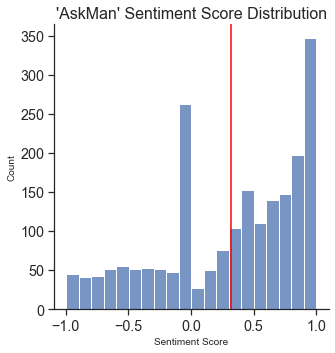

In [111]:
plt.tight_layout()
sns.displot(df_man_sentiment.score, bins=20,palette='pastel')
sns.color_palette("pastel")
plt.xlabel("Sentiment Score", size=10)
plt.ylabel("Count", size=10)
plt.axvline(x=df_man_sentiment.score.mean(),
            color='red')
plt.title("'AskMan' Sentiment Score Distribution", size = 16)
plt.savefig('../resources/AskManSantiment.png')


A lot of neutral scores, and peek for positive ones.

AskWoman submissions

In [112]:
result=[]

for wcomment in final_df[final_df["sex"]==0]["comment"]:    
    score=sent.polarity_scores(wcomment)
    temp={"comment":wcomment,"score":score["compound"]}
    result.append(temp)
df_woman_sentiment=pd.DataFrame(result)


Plotting AskWoman submission scores

<Figure size 432x288 with 0 Axes>

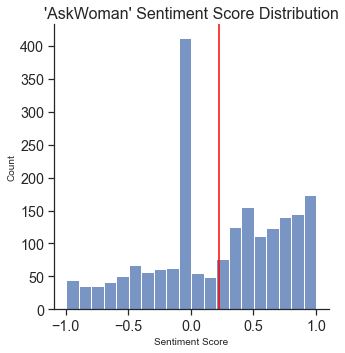

In [113]:
plt.tight_layout()
sns.displot(df_woman_sentiment.score, bins=20)
plt.xlabel("Sentiment Score", size=10)
plt.ylabel("Count", size=10)
plt.axvline(x=df_woman_sentiment.score.mean(),
            color='red')
plt.title("'AskWoman' Sentiment Score Distribution", size = 16)
plt.savefig('../resources/AskWomanSantiment.png')


A lot of neutral commentaries.

----

##### Check for outliers

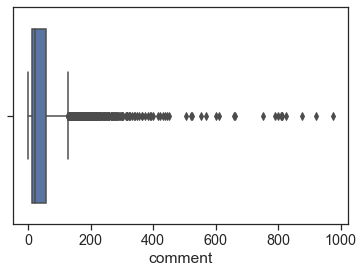

In [114]:

plt.tight_layout()
sns.boxplot(final_df['comment'].str.split(" ").str.len())
plt.savefig('../resources/BoxPlot.png')

In [115]:
final_df[(np.abs(stats.zscore(final_df["comment"].str.len())) > 3)]


,comment,sex
81,over here canada have some restriction currently place that shut down lot social place our restaurant take out only right now and bar completely close use occasionally to the club and social when have the opportunity but even then people restrict their table and really hinder the social part not currently school right now don have that social aspect my life meet people and interact understand ...,1
85,worry that just deny because feel ashamed think lose this isn the case honest don have issue he want sleep with other girl understand some people just like that and want he happy use have issue with as lie I when find out hit this other woman while say want exclusive but don anymore however have issue with dishonesty also portray lot thing differently the begin our relationship like how strong...,1
181,this difficult one date this girl for and half month and date with she our date generally really good and she act interest she the sweetest most lie back lady meet think myself this too good true she like kiss and have sex the date she take back her place hell yesterday morning she cook breakfast for from her own heart while sit and watch good point her dad know abou...,1
208,so just get out year relationship not too long ago about over month and the break come for awhile only couple day later the person have lot history he in ex coworker and use just have casual sex texte we then few night later have sex and pick up and intention sleepover his apartment cuddle which never happen before and watch netflix the next morning and take home not...,1
246,hey guy year old man here my final year university date for the past year and leave disillusioned and weary really lose interest it because haven make much headway after year all friend this point seem atleast one two relationship under their belt just feel like miss out the most fun year my life term date and sex and hard not feel negative and angry about we in our ...,1
...,...,...
3816,tldr lot movie and show have unnecessary scene especially write man and just wonder how you guy feel about the story author when you see these thing especially when frequently in perverse way long version for abhor pe scene especially they unnecessary frequent and have purpose sometimes even loathe own gender when watch scene where the scene make out sexy with show try show the sex part it mor...,0
3843,english not first language ex and meet university re study together now re from latin america she an instagram model didn have social medium she make one from day one meet school click quickly agree not involve emotionally amp give year she don marry she shoot when not around she text to know where amp keep call texting until join she and her friend we use hang out every day week after kiss am...,0
3866,talk this girl for little bit now she be friend now for long time very many year not like close like friendzone anything but recently kind start talk again recently out narcissistically abusive relationship end there decent chance this girl talk quite narcissist imagine the easy good way give you impression this new girl she kind like trailer park trashy loud fun around always talk about every...,0
3935,not quite sure this the appropriate sub but here go and sorry kind of long don get wrong really like wear earring wear they pretty consistently until high school and almost always they stud as mom call they keep earring however have bad habit lose one the two stud render the remain one practically useless don wear earring very much now mainly because they hurt but also because don buy cute ear...,0


There are 72 rows with text length more than 3 standart deviations. Concidering, that these values occured not because of the technical error I'll keep them.

##### Dropping Stopwords

In [116]:
# I am using both SpaCy and nltk colections, as they are slightly different
def drop_stopwords(str):
    result=""
    for word in str.split(' '):
        if word not in nlp.Defaults.stop_words:
            if word not in stopwords.words('english'):
                result+=word
                result+=" "

    return result.strip()

In [117]:
df=final_df.copy()
df['comment']=df['comment'].apply(lambda x: drop_stopwords(x))
df=df[df['comment']!=""]


Saving point

In [118]:
#saving file
df.to_csv("../data/df_submissions.csv",index=False)

In [119]:
df["sub_word_count"]=df['comment'].str.split(" ").str.len()
df["sub_length"]= df['comment'].str.len()

##### EDA by subreddits

In [120]:
df.groupby('sex').agg(['mean',"max","min"])

sub_word_count           sub_length          
              mean  max min        mean   max min
sex                                              
0        22.240399  559   1  122.865337  2732   1
1        30.750000  379   1  168.301859  2072   2

Submissions at AskMan are 40 percents longer, than at AskWoman and have 25 percent more words. But the longest by length and by words amount submissions are in AskWoman section.

Plot of words and submission length distributions

<Figure size 432x288 with 0 Axes>

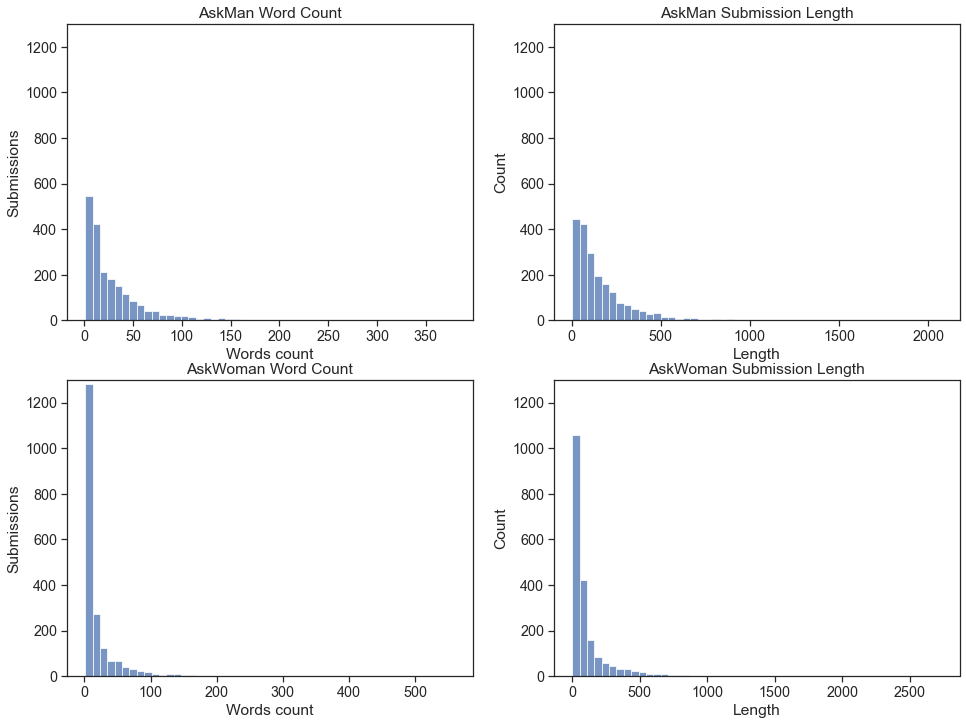

In [121]:
plt.tight_layout()

plt.subplots_adjust(hspace=.2)
plt.figure(figsize=(16,12))
plt.subplot(2, 2, 1)
#AskMan Word Count
plt.title('AskMan Word Count')
sns.histplot(df[df["sex"]==1]['sub_word_count'],bins=50,)
plt.ylim(0, 1300)
plt.xlabel('Words count')
plt.ylabel('Submissions')
#AskMan Submission Length
plt.subplot(2, 2, 2)
plt.title('AskMan Submission Length')
sns.histplot(df[df["sex"]==1]['sub_length'],bins=50)
plt.ylim(0, 1300)
plt.xlabel('Length')
plt.ylabel('Count')
#AskWoman Word Count
plt.subplot(2, 2, 3)
plt.title('AskWoman Word Count')
sns.histplot(df[df["sex"]==0]['sub_word_count'],bins=50,)
plt.ylim(0, 1300)
plt.xlabel('Words count')
plt.ylabel('Submissions')
#AskWoman Submission Length
plt.subplot(2, 2, 4)
plt.title('AskWoman Submission Length')
sns.histplot(df[df["sex"]==0]['sub_length'],bins=50)
plt.ylim(0, 1300)
plt.xlabel('Length')
plt.ylabel('Count')

plt.savefig('../resources/Distribution_submissions.png')
plt.show()

Despite some different peaks, they look very similar

##### Summary

Word count statisticks

In [122]:
print(df[df["sex"]==1]['sub_word_count'].describe())
df[df["sex"]==0]['sub_word_count'].describe()

count    2044.00000
mean       30.75000
std        36.64519
min         1.00000
25%         8.00000
50%        18.00000
75%        40.00000
max       379.00000
Name: sub_word_count, dtype: float64


count    2005.000000
mean       22.240399
std        42.415115
min         1.000000
25%         5.000000
50%         8.000000
75%        20.000000
max       559.000000
Name: sub_word_count, dtype: float64

Submission length statisticks

In [123]:
df[df["sex"]==1]['sub_length'].describe(),df[df["sex"]==0]['sub_length'].describe()

(count    2044.000000
 mean      168.301859
 std       196.577701
 min         2.000000
 25%        49.000000
 50%       104.000000
 75%       215.000000
 max      2072.000000
 Name: sub_length, dtype: float64,
 count    2005.000000
 mean      122.865337
 std       221.796095
 min         1.000000
 25%        30.000000
 50%        52.000000
 75%       117.000000
 max      2732.000000
 Name: sub_length, dtype: float64)

Heatmap

<AxesSubplot:>

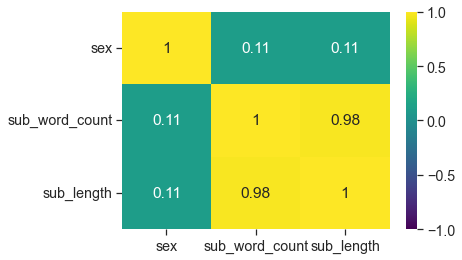

In [124]:
sns.heatmap(df.corr(),annot=True, vmin=-1,vmax=1,cmap="viridis")

Strong correaltion between word count, and submission lenght. But that is essential.

Pairplot

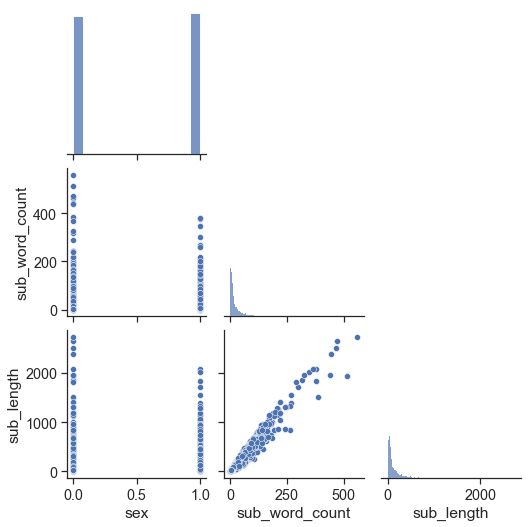

In [125]:
sns.pairplot(df,corner=True)

Strong correaltion between word count, and submission lenght. But that is essential.

_____
##### Finding bigrams

In [126]:

def bigrams_clean(list_f):
    try:
       for x in list_f:
         if x=="":
          return "np.NAN"
         elif x==" ":   
            return "np.NAN"
         else:

            return list_f
          
    except:
       p=1


In [127]:
bigram_freq = lambda s: list(nltk.FreqDist(nltk.bigrams(s.strip().split(" "))).items())

out = df['comment'].apply(bigram_freq).explode()


out = pd.DataFrame(out.to_list(), index=out.index, columns=["submissions", "bigrams"])
#bigram made some mistakes, so I had to make cleaning
for x,k in enumerate(out.iloc[:,0]):
    try:
        if k[0]=="":
            out.iloc[x,0]=np.nan
        if k[1]=="":
            out.iloc[x,0]=np.nan
    except:
        p=1
out=out.dropna()
bigram_count=out["submissions"].value_counts().head(20)

Plotting a bar graph of the most frequnt bigrams


<Figure size 432x288 with 0 Axes>

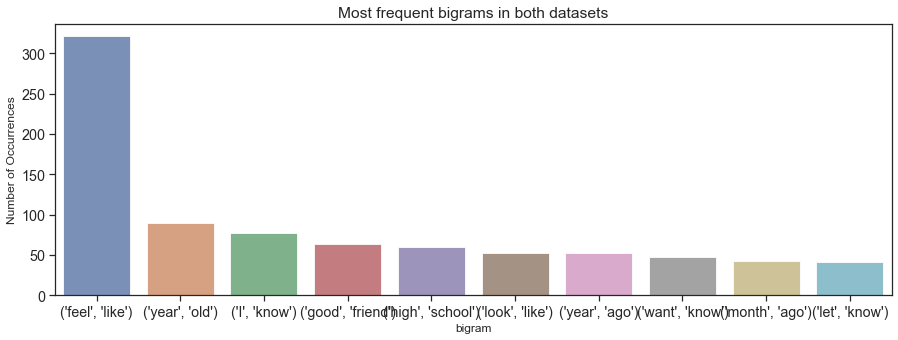

In [128]:
# Plotting a bar graph of the most frequnt bigrams
plt.tight_layout()
bigram_count = bigram_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(bigram_count.index, bigram_count.values, alpha=0.8)
plt.title('Most frequent bigrams in both datasets')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bigram', fontsize=12)
plt.savefig('../resources/bigrams.png')
plt.show();

Most of bigrams are basic expressions and common words pairs

In [129]:
bigram_freq = lambda s: list(nltk.FreqDist(nltk.trigrams(s.split(" "))).items())

out = df['comment'].apply(bigram_freq).explode()
out = pd.DataFrame(out.to_list(), index=out.index, columns=["submissions", "bigrams"])
for x,k in enumerate(out.iloc[:,0]):
    try:
        if k[0]=="":
            out.iloc[x,0]=np.nan
        if k[1]=="":
            out.iloc[x,0]=np.nan
        if k[2]=="":
            out.iloc[x,0]=np.nan
    except:
        p=1
out=out.dropna()
trigram_count=out["submissions"].value_counts().head(20)

<Figure size 432x288 with 0 Axes>

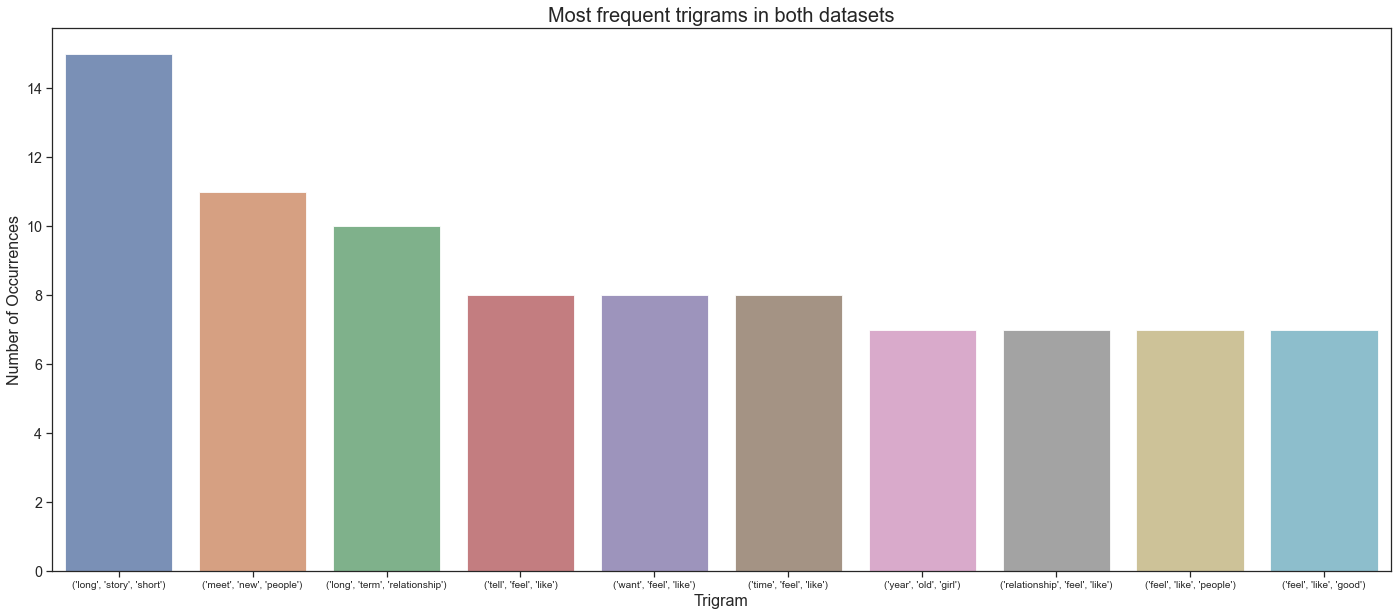

In [130]:
# Plotting a bar graph of the most frequnt bigrams
plt.tight_layout()
trigram_count = trigram_count[:10,]
plt.figure(figsize=(24,10))
sns.barplot(trigram_count.index, trigram_count.values, alpha=0.8)
plt.title('Most frequent trigrams in both datasets',fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Trigram', fontsize=16)
plt.xticks(fontsize=10)
plt.savefig('../resources/trigrams.png')
plt.show();

All of those are basic expressions.

----
Tokenization and most frequent words

In [131]:
def get_tokens(docs):
    df_tokens = []
    for x in docs:
        man=nlp(x)
        for token in man:
            t_dict = {
            'text': token,
            'POS': token.pos_,
            'POS explained': spacy.explain(token.pos_),        
            'lemma': token.lemma_
            }
            df_tokens.append(t_dict)
        
    return pd.DataFrame(df_tokens)

In [132]:
docs_man = list(nlp.pipe(df[df['sex']==1]["comment"]))
docs_woman = list(nlp.pipe(df[df['sex']==0]["comment"]))

In [133]:
df_man_tokens=get_tokens(docs_man)
df_woman_tokens=get_tokens(docs_woman)


In [134]:
df_man_tokens=df_man_tokens[df_man_tokens["POS"]!="AUX"]
df_man_tokens=df_man_tokens[df_man_tokens["POS"]!="SPACE"]
df_woman_tokens=df_woman_tokens[df_woman_tokens["POS"]!="SPACE"]
df_woman_tokens=df_woman_tokens[df_woman_tokens["POS"]!="SPACE"]


In [135]:
df_man_tokens.shape,len(set(df_man_tokens.lemma)),df_woman_tokens.shape,len(set(df_woman_tokens.lemma))

((52378, 4), 5964, (37435, 4), 5098)

From 2050 submissions we got 5964 unique words for AskMan and 5097 unique words for AskWoman.

In [136]:
df_man_tokens.reset_index(inplace=True)
df_man_tokens.drop(columns='index',inplace=True)

<Figure size 1080x1080 with 0 Axes>

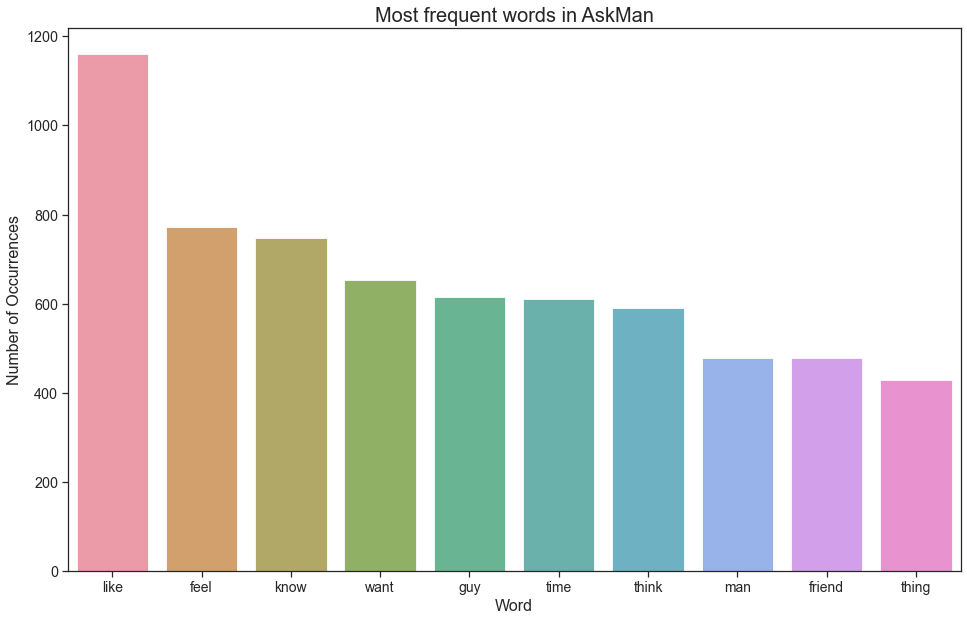

In [137]:
plt.figure(figsize=(15,15))
man_count=df_man_tokens["lemma"].value_counts().sort_values(ascending=False).head(10)


# Plotting a bar graph of the most frequnt words
plt.tight_layout()
plt.figure(figsize=(16,10))
sns.barplot(man_count.index, man_count.values, alpha=0.8,palette='husl')
plt.title('Most frequent words in AskMan',fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Word', fontsize=16)
plt.xticks(fontsize=14)
plt.savefig('../resources/AskManWords.png')
plt.show()

These words are so common and being used so often, that we can try to consider them as stopwords to see if that will affect modeling effectiveness.


### Now let's look at the most popular words in the AskWoman section

<Figure size 432x288 with 0 Axes>

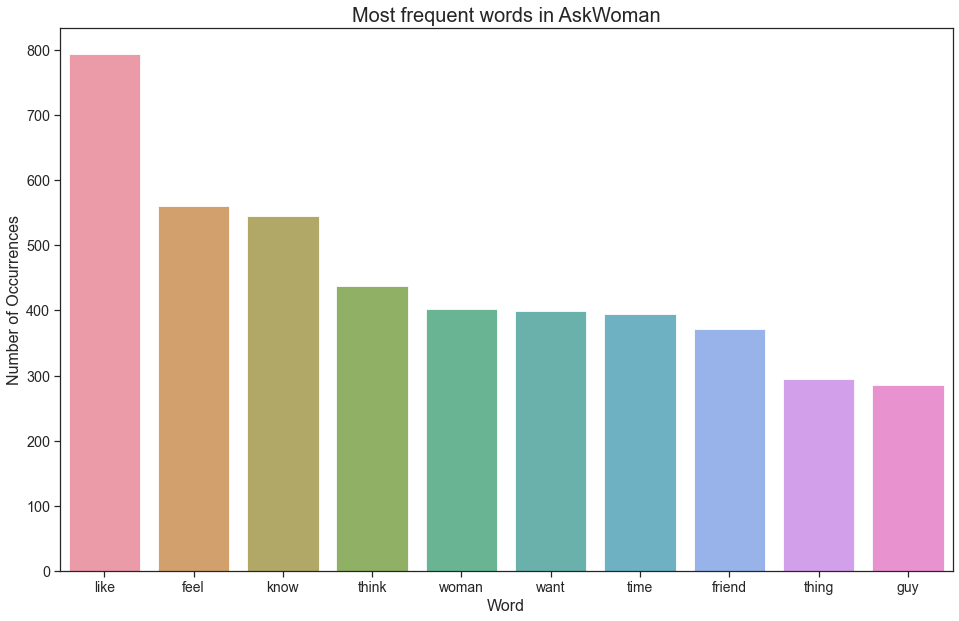

In [138]:
df_woman_tokens=df_woman_tokens[df_woman_tokens["POS"]!="AUX"]
df_woman_tokens=df_woman_tokens[df_woman_tokens["POS"]!="SPACE"]
# df_woman_tokens=df_woman_tokens[df_woman_tokens["POS"]!="PROPN"]
df_woman_tokens.reset_index(inplace=True)
df_woman_tokens.drop(columns='index',inplace=True)
woman_count=df_woman_tokens["lemma"].value_counts().sort_values(ascending=False).head(10)

# Plotting a bar graph of the most frequnt words
plt.tight_layout()
plt.figure(figsize=(16,10))
sns.barplot(woman_count.index, woman_count.values, alpha=0.8,palette='husl')
plt.title('Most frequent words in AskWoman',fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Word', fontsize=16)
plt.xticks(fontsize=14)
plt.savefig('../resources/AskWomanWords.png')
plt.show()

Same here,these words are so common and being used so often, that we can try to consider them as stopwords to see if that will affect modeling effectiveness.
